## 从轨道断面客流数据绘制轨道客流的可视化
提供的基础数据是：

GIS文件：
1.上海轨道2号线-线形
2.上海轨道2号线-站点

数据：
1.上海轨道2号线-断面客流（数据纯属虚构，练手用）

### 1.读取数据

In [22]:
import geopandas as gpd
shp = r'shapefile\metroline2\metroline2.shp'
line = gpd.GeoDataFrame.from_file(shp,encoding = 'utf-8')
line

,city,linename,geometry
0,上海,地铁2号线(徐泾东-浦东国际机场),"LINESTRING (121.29660 31.19123, 121.30094 31.1..."
1,上海,地铁2号线(浦东国际机场-徐泾东),"LINESTRING (121.80240 31.15162, 121.80132 31.1..."


<AxesSubplot:>

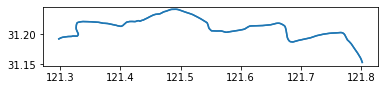

In [23]:
#画出线路
line.plot()

In [24]:
import pandas as pd
stop = pd.read_csv(r'data-sample\metrostop2.csv')
stop.head(5)

,stationnames,linename,lon,lat
0,徐泾东,地铁2号线(徐泾东-浦东国际机场),121.294879,31.190269
1,虹桥火车站,地铁2号线(徐泾东-浦东国际机场),121.316980,31.195925
2,虹桥2号航站楼,地铁2号线(徐泾东-浦东国际机场),121.321726,31.196596
3,淞虹路,地铁2号线(徐泾东-浦东国际机场),121.354842,31.220001
4,北新泾,地铁2号线(徐泾东-浦东国际机场),121.369405,31.218306


In [25]:
import pandas as pd
data = pd.read_csv(r'data-sample\metrodata-sample.csv',encoding = 'utf-8')
data.head(5)

,FROMSTATIONAME,TOSTATIONAME,FLOW
0,徐泾东,虹桥火车站,1223
1,虹桥火车站,徐泾东,1785
2,虹桥火车站,虹桥2号航站楼,4333
3,虹桥2号航站楼,虹桥火车站,4851
4,虹桥2号航站楼,淞虹路,4105


可视化思路
<img src="metro1.png" style="width:1000px">

### 2.对一个方向的轨道线进行GIS处理
先取一个方向的轨道线数据

In [26]:
linename = line['linename'].drop_duplicates().iloc[1]
linename

'地铁2号线(浦东国际机场-徐泾东)'

In [27]:
stop_1 = stop[stop['linename'] == linename]
line_1 = line[line['linename'] == linename]

D:\miniconda3\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\aaa\AppData\Local\Temp\ipykernel_17708\3160860492.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stop_1['geometry'] = stop_1.apply(lambda r:Point(r['lon'],r['lat']),axis = 1)


<AxesSubplot:>

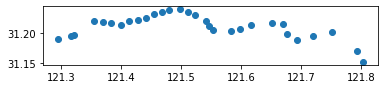

In [28]:
#将站点数据变为geopandas，并画出来
from shapely.geometry import Point,Polygon
stop_1['geometry'] = stop_1.apply(lambda r:Point(r['lon'],r['lat']),axis = 1)
stop_1 = gpd.GeoDataFrame(stop_1)

stop_1.plot()

shapely的简介  
在前面，我们已经初步接触过shapely，geopandas是基于shapely的，geodataframe的每个图形，都是一个shapely的geometry。  
同时，geopandas也继承了shapely的一些gis处理方法，但只是一些  
结合geopandas自带的一些gis处理功能，和更底层的shapely的gis处理功能，我们可以更自由地在python中完成一些gis操作  

### 3.将轨道切分为线段
我们要实现的操作是：
<img src="metro2.png" style="width:1000px">
然后，将断面客流的数据匹配到上面的每一段上


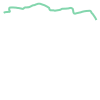

In [29]:
# 首先，我们来将轨道切成段
#把 点 和 线 都变成整体
#对geodataframe执行unary_union操作后，他们都会变成一个shapely的geometry对象
stop_1_geo = stop_1.unary_union
line_1_geo = line_1.unary_union
line_1_geo

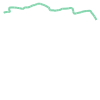

In [30]:
#切分
from shapely.ops import split
#用shapely的split功能切分线，这里，因为点的位置不一定在线上（就算在线上，由于小数点取值问题也可能不会精确的在线上）
#所以，对点进行buffer以后，再用buffer来切分线
split_line = split(line_1_geo,stop_1_geo.buffer(0.0008))
split_line

<AxesSubplot:>

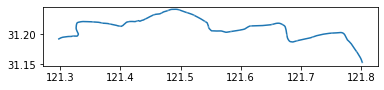

In [31]:
#用切分的线段生成geodataframe，命名为splited_line变量
splited_line=gpd.GeoDataFrame({'geometry':split_line})
splited_line['linename'] = linename

splited_line.plot()

In [32]:
splited_line.head()

,geometry,linename
0,"LINESTRING (121.80240 31.15162, 121.80213 31.1...",地铁2号线(浦东国际机场-徐泾东)
1,"LINESTRING (121.80213 31.15237, 121.80132 31.1...",地铁2号线(浦东国际机场-徐泾东)
2,"LINESTRING (121.79306 31.16992, 121.79252 31.1...",地铁2号线(浦东国际机场-徐泾东)
3,"LINESTRING (121.79214 31.17123, 121.79060 31.1...",地铁2号线(浦东国际机场-徐泾东)
4,"LINESTRING (121.75189 31.20151, 121.75123 31.2...",地铁2号线(浦东国际机场-徐泾东)


切分后生成的每一段地铁线路，我们需要添加信息表示它是从哪个站到哪个站，这样，下一步就可以将流量数据匹配上去了
因此我们下一步做的是，把线段的起点和终点匹配到最近的站点

来试试！把其中一段取出来匹配

In [33]:
import math
import numpy as np
# 得到得到起点与终点的函数
def getstartendstation(lineshp,stop_1):
    #起点坐标是
    startlon,startlat = lineshp.coords[0]
    #终点坐标是
    endlon,endlat = lineshp.coords[-1]

    #在stop_1中找出离起点和终点最近的站点名字吧
    #把站点名字存放在start和end变量中
    stop_1['dis'] = np.sqrt(pow(abs(stop_1['lon']-startlon),2)+pow(abs(stop_1['lat']-startlat),2))  #这里需要使用np.sqrt，不能使用math.sqrt
    start = stop_1[stop_1['dis'] == stop_1['dis'].min()]['stationnames'].iloc[0]

    stop_1['dis'] = np.sqrt(pow(abs(stop_1['lon']-endlon),2)+pow(abs(stop_1['lat']-endlat),2))
    end = stop_1[stop_1['dis'] == stop_1['dis'].min()]['stationnames'].iloc[0]
    
    
    return start,end

In [34]:
station_a={}
station_b={}
splited_lines=splited_line

for i in range(0,len(splited_line.geometry)):  #循环提取起点终点
    lineshp = splited_line.geometry.iloc[i]
    start,end=getstartendstation(lineshp,stop_1)
    station_a[i]=start
    station_b[i]=end
    

splited_lines['station_a']=station_a.values()
splited_lines['station_b']=station_b.values()
splited_lines=splited_lines[-(splited_lines['station_a']==splited_lines['station_b'])]   #删除起点终点相等的


In [35]:
#根据起点终点合并，使用merge函数
splited_lines=pd.merge(splited_lines,data,left_on=['station_a','station_b'],right_on=['FROMSTATIONAME','TOSTATIONAME']);
splited_lines.head()

,geometry,linename,station_a,station_b,FROMSTATIONAME,TOSTATIONAME,FLOW
0,"LINESTRING (121.80213 31.15237, 121.80132 31.1...",地铁2号线(浦东国际机场-徐泾东),浦东国际机场,海天三路,浦东国际机场,海天三路,746
1,"LINESTRING (121.79214 31.17123, 121.79060 31.1...",地铁2号线(浦东国际机场-徐泾东),海天三路,远东大道,海天三路,远东大道,825
2,"LINESTRING (121.75030 31.20140, 121.74693 31.2...",地铁2号线(浦东国际机场-徐泾东),远东大道,凌空路,远东大道,凌空路,864
3,"LINESTRING (121.71896 31.19474, 121.71596 31.1...",地铁2号线(浦东国际机场-徐泾东),凌空路,川沙,凌空路,川沙,1201
4,"LINESTRING (121.69296 31.18854, 121.69168 31.1...",地铁2号线(浦东国际机场-徐泾东),川沙,华夏东路,川沙,华夏东路,2504


<AxesSubplot:>

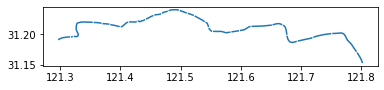

In [36]:
splited_lines.plot()

### 4.将线段变成面  
<img src="metro3.png" style="width:1000px">
首先，根据流量，对每一段分组，这个用我们之前的OD绘制时宽度的分组方法。  

分10组，保存在linewidth中，最大的是1，最小的是0.1  

In [37]:
import numpy as np
#生成段
step = 10
splited_lines = splited_lines.sort_values(by = 'FLOW')
splited_lines['linewidth'] = (np.array(range(len(splited_lines)))*step/len(splited_lines)).astype('int')/step+0.1

splited_lines.head()

,geometry,linename,station_a,station_b,FROMSTATIONAME,TOSTATIONAME,FLOW,linewidth
0,"LINESTRING (121.80213 31.15237, 121.80132 31.1...",地铁2号线(浦东国际机场-徐泾东),浦东国际机场,海天三路,浦东国际机场,海天三路,746,0.1
1,"LINESTRING (121.79214 31.17123, 121.79060 31.1...",地铁2号线(浦东国际机场-徐泾东),海天三路,远东大道,海天三路,远东大道,825,0.1
2,"LINESTRING (121.75030 31.20140, 121.74693 31.2...",地铁2号线(浦东国际机场-徐泾东),远东大道,凌空路,远东大道,凌空路,864,0.1
3,"LINESTRING (121.71896 31.19474, 121.71596 31.1...",地铁2号线(浦东国际机场-徐泾东),凌空路,川沙,凌空路,川沙,1201,0.2
28,"LINESTRING (121.31618 31.19590, 121.31323 31.1...",地铁2号线(浦东国际机场-徐泾东),虹桥火车站,徐泾东,虹桥火车站,徐泾东,1785,0.2


In [38]:
#新建一个变量，splited_duans来存储生成的面
splited_duans = splited_lines.copy()

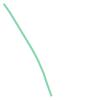

In [39]:
#接下来，由线生成面，同样的，我们拿一条出来试试
#设定一下我们想要的面宽度
kuandu = 0.005
r = splited_lines.iloc[0]
theline = r['geometry']

#立即使用shapely的parallel_offset功能
offsetline = r['geometry'].parallel_offset(kuandu*r['linewidth'],join_style = 3)
offsetline

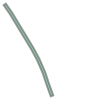

In [40]:
#把theline和offsetline的坐标提取出来，用Polygon生成面，暂时命名为ply吧

ply = Polygon(np.append(np.array(theline.coords),
        np.array(offsetline.coords)).reshape(-1,2))

ply

<AxesSubplot:>

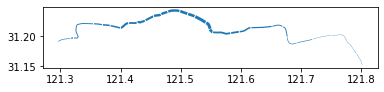

In [41]:
#OK，下一步，对每一段都应用上面的方法，把生成的polygon放到一个list变量里然后赋值给splited_duans的geometry
geo = []

for i in range(len(splited_lines)):
    r = splited_lines.iloc[i]
    ply = Polygon(np.append(np.array(r['geometry'].coords),
    np.array(r['geometry'].parallel_offset(kuandu*r['linewidth'],join_style = 3).coords)).reshape(-1,2))
    geo.append(ply)

splited_duans['geometry'] = geo

splited_duans1 = splited_duans.copy()
splited_duans.plot()

### 5.可视化出图


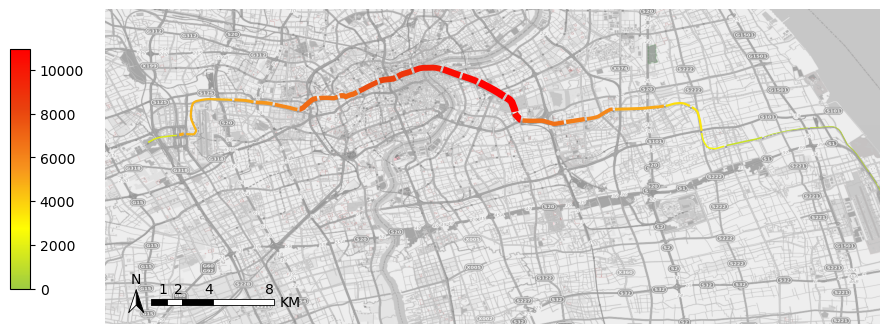

In [42]:
#设定显示范围
lat1sh = 30.8666667;
lat2sh = 31.5833333;
lon1sh = 121.066667;
lon2sh = 122.0;
bounds = [lon1sh+0.2,lat1sh+0.2,lon2sh-0.2,lat2sh-0.3]

import plot_map
#导入必要的包
import pandas as pd
import numpy as np
#绘制图用的包
import matplotlib as mpl
import matplotlib.pyplot as plt
#geopandas包
import geopandas

#定义画的大小
fig     = plt.figure(1,(10,8),dpi = 100)    
ax      = plt.subplot(111)
plt.sca(ax)

#plot_map包绘制背景图
plot_map.plot_map(plt,bounds,zoom = 12,style = 4)

#设定colormap
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', ['#9DCC42','#FFFE03','#F7941D','#E9420E','#FF0000'], 256)
vmax = splited_duans['FLOW'].max()

#把前面搞出来的画上去
splited_duans1.plot(ax=ax, column='FLOW', lw=4, cmap=cmap,vmin = 0,vmax = vmax)
#splited_duans2.plot(ax=ax, column='FLOW', lw=4, cmap=cmap,vmin = 0,vmax = vmax)

# 加比例尺和指北针
plot_map.plotscale(ax,bounds = bounds,textsize = 10,compasssize = 1,accuracy = 1000,rect = [0.06,0.06])

#设定显示范围
plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])

#绘制colorbar
plt.imshow([[0,vmax]], cmap=cmap)
cax = plt.axes([0.03, 0.35, 0.02, 0.3])
plt.colorbar(cax=cax)

plt.show()